# <center> TP 3 : Apprentissage d'un mélange - Algorithme EM

## Chargement des données MNIST

In [1]:
%pylab
%matplotlib inline 

from mnist import load_mnist
import numpy as np
import visualize as vz
import random as rd

train_data, train_labels = load_mnist(dataset='training', path='./')
test_data, test_labels = load_mnist(dataset='testing', path='./')

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


Transformation de `train_data` et `test_data` en vecteur colonne pour chaque exemple.

In [2]:
train_data = np.reshape(train_data, (60000, 28 * 28)).T
test_data  = np.reshape(test_data,  (10000, 28 * 28)).T

Binarisation des données :

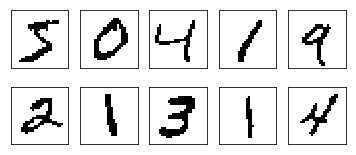

In [3]:
binarize = lambda x : x < 128 / 255
vfunc = np.vectorize(binarize)
train_data = vfunc(train_data)
test_data = vfunc(test_data)

vz.plotGroupImages(train_data[:, :10])

## Partie 1 : Théorie

A partir de ce qui a été vu en cours, déduire les étapes de l'algorithme EM pour l'apprentissage des paramètres d'un mélange de loi de Bernoulli. Donner les formules de mise à jour des différents paramètres du modèle.

L'algorithme EM fonctionne suivant deux étapes :
* L'étape appelée "expectation", qui consiste à calculer tous les poids de tous les points pour toutes les composantes.
* L'étape appelée "maximization", qui vise à recalculer les moyennes pour chaque composante, en modifiant les poids de chaque composante.

On pose N correspondant aux nombres d'éléments dans le dataset {$X_1, \ldots, X_n$}, K correspondant aux nombres de composantes souhaitées,
$w_i$ le poid associé à la i-ème composante.

**Etape 1 : Initialisation des paramètres**

* Initialisation des moyennes de chaque composante.
* Initialisation des poids, tels que $\sum_{i=1}^{K}{w_i} = \sum_{i=1}^K{P(i)} = 1$.

**Etape 2 : Expectation**

* Nous savons que la vraisemblance $P(X_i | \mu_k) = \mu_k^{X_i} (1 − \mu_k)^{N − X_i}$ en utilisant une distribution de Bernoulli.
* On calcule l'a posteriori : $P(k|X_i) = \frac{w_k P(X_i|\mu_k)}{\sum_{j=1}^{K}{w_j P(X_j|\mu_k)}} = \frac{w_k (\mu_k^{X_i} (1 − \mu_k)^{N − X_i})}{\sum_{j=1}^{K}{w_j (\mu_k^{X_j}(1 − \mu_k)^{N − X_j})}}$

**Etape 3 : Maximization**

* On calcule de nouveaux poids : $P(k) = w_k = \frac{\sum_{i=1}^{N}{P(k|X_i)}}{N}$
* On calcule les nouvelles moyennes : $\mu_k = \frac{\sum_{i=1}^{N}{P(k|X_i)X_i}}{\sum_{i=1}^{N}{P(k|X_i)}}$

## Partie 2 : Implémentation

On vous demandera de tester différentes valeurs pour le nombre de composantes du mélange ainsi que différentes initialisations du modèle.

**1.** Implémenter cet algorithme et faire l'apprentissage sur les données binaires TRAINB obtenues précedemment. Attention à la manipulation des valeurs de probabilités (entre 0 et 1) qui deviennent rapidement nulles à cause de la précision des chiffres flottants.

In [4]:
class EmBernoulli:
    def __init__(self, data, nbComponents):
        self.data = data
        self.nbComponents = nbComponents

    def _init_center(self):
        self.center = np.zeros((self.data.shape[0], self.nbComponents))
        minimages = self.data.shape[1] // 4
        for i in range(self.nbComponents):
            mini = 0
            maxi = rd.randint(minimages, self.data.shape[1])
            self.center[:, i] = np.mean(self.data[:, mini:maxi], axis=1)

    def computeEM(self):
        delta = 1e-2
        # P(k)
        self.W = np.repeat(1 / self.nbComponents, self.nbComponents)
        self._init_center()
        
        while True:
            self._expectationStep()
            newW, newCenter = self._maximizationStep()
            diff = np.sum(np.abs(newW - self.W))
            #print(diff)
            if diff < delta:
                print("EM done!")
                return newW, newCenter
            self.W = newW
            self.center = newCenter

    def _bernoulli(self, x, center):
        # proba is P(X1, ..., Xn)
        proba = np.zeros(x.shape)
        # Retrieve indices of black and white pixels.
        indices = [np.array(np.where(x == i)) for i in range(2)]
        proba[indices[0]] = 1 - center[indices[0]]
        proba[indices[1]] = center[indices[1]]
        prod = np.prod(proba)

        # This lines allow to fix NaN problems,
        # by replacing them by smallest epsilon
        if np.isnan(prod) or prod <= 0:
            return np.finfo(prod.dtype).tiny
        return prod

    def _expectationStep(self):
        N = self.data.shape[1]
        K = self.nbComponents
        self.tabl = np.zeros((N, K))

        for n in range(N):
            for k in range(K):
                # Probability for the image to be from K class.
                self.tabl[n, k] = np.log(self._bernoulli(self.data[:, n], self.center[:, k])) + np.log(self.W[k])
                
            maxValue = np.amax(self.tabl[n, :])
            normTabl = self.tabl[n, :] - maxValue
            tablSum = np.sum(np.exp(normTabl))
            self.tabl[n, :] = np.exp(normTabl - np.log(tablSum))

    def _maximizationStep(self):
        N = self.tabl.shape[0]
        tsum = np.sum(self.tabl, axis=0)
        W =  tsum / N
        center = np.dot(self.data, self.tabl) / tsum
        return W, center

In [5]:
#train_classes = [train_data[:, np.where(train_labels == i)[0]]
#                        for i in range(10)]
#emb = EmBernoulli(train_classes[3], 4)
#W, center = emb.computeEM()

**2.** Afficher les moyennes des différentes distributions de Bernoulli ?

In [6]:
#vz.plotGroupImages(center)

**3.** En utilisant uniquement 10 composantes, est-il possible d'avoir un centre par classe ? Justifier.

Non, il n'est pas possible d'utiliser un centre par classe, car, comme affiché ci-dessus, les centres obtenus peuvent être "proches", ne permettant pas de les distinguer les uns entre les autres. Par exemple, le "7" et le "1" ont tendance à se ressembler, tout comme le "3" et le "8".

In [7]:
#emb = EmBernoulli(train_data, 10)
#W, center = emb.computeEM()
#vz.plotGroupImages(center)

**4.** Tester un classifieur bayésien en utilisant un mélange pour chaque classe ? Quel est le taux de reconnaissance obtenu (tester 1, 2, 4, et 8 composantes par classe) ?

In [8]:
class BernouilliClassifier:    
    def train(self, train_data, train_labels, nb_comp):
        tinier = np.vectorize(lambda x : np.finfo(centers.dtype).tiny if x <= 0 else x)
        
        self.nb_classes = np.unique(train_labels).shape[0]
        self.train_data = train_data
        self.train_labels = train_labels
        self.nb_comp = nb_comp
        self.centers_by_class = np.zeros((self.nb_classes, train_data.shape[0], self.nb_comp))
        self.neg_centers_by_class = np.zeros((self.nb_classes, train_data.shape[0], self.nb_comp))
        
        for i in range(self.nb_classes):
            emb = EmBernoulli(self.train_data[:, np.where(train_labels == i)[0]], self.nb_comp)
            _, centers = emb.computeEM()
            self.centers_by_class[i] = np.log(centers)
            invcenters = tinier(1 - centers)
            self.neg_centers_by_class[i] = np.log(invcenters)
            
    def process(self, data):
        nb_samples = data.shape[1]
        result = np.zeros((data.shape[1]))
        for i in range(nb_samples):
            prob = np.zeros((self.nb_classes, self.nb_comp))
            for k in range(self.nb_classes):
                x = data[:, i]
                prob[k] = x.T.dot(self.centers_by_class[k]) + (1 - x).T.dot(self.neg_centers_by_class[k])
            result[i] = np.unravel_index(np.argmax(prob), (self.nb_classes, self.nb_comp))[0]
        return result
            

In [9]:
nb_components = [1, 2, 4, 8]
bc = BernouilliClassifier()
for i in nb_components:
    bc.train(train_data, train_labels, i)
    # Checks performance
    out = bc.process(test_data)
    score = (out == test_labels).sum() / test_labels.shape[0]
    print("Perf with", i, "components", score)

EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
Perf with 1 components 0.8434
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
Perf with 2 components 0.863
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
Perf with 4 components 0.9031
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
EM done!
Perf with 8 components 0.9253


## Partie 3 : Comparaison avec un GMM

Comparer les résultats obtenus avec le cas d'un mélange de gaussiennes sur les données brutes TRAIN et TEST.

* On a $N(X; \mu, \Theta) = \frac{1}{\sqrt{(2\pi)^D|\Theta|}} exp(-0.5(X - \mu)^T\Theta^{-1}(X - \mu))$
* La vraisemblance : $P(k|X) = \frac{w_k N(X;\mu_k,\Theta_k)}{\sum_{j=1}^{N}{w_j N(X,\mu_j,\Theta_j)}}$
* $P(k) = \frac{\sum_{i=1}^{N}{P(k|X_i)}}{N}$
* $\mu_k = \frac{\sum_{i=1}^{N}{P(k|X_i)X_i}}{\sum_{i=1}^{N}{P(k|X_i)}}$
* $\Theta_k = \frac{\sum_{i=1}^{N}{P(k|X_i)(X_i - \mu_k)^2}}{\sum_{i=1}^{N}{P(k|X_i)}}$

**1.** Envisager le cas de gaussienne avec des matrices de covariance diagonale, ensuite tester la version avec matrices de covariance complètes.

In [10]:
class EmGaussian:
    def _init_center_cov(self):
        self.center = np.zeros((self.data.shape[0], self.nbComponents))
        #cov = [np.zeros((data.shape[0], data.shape[0])) for i in
        #        range(nbComponents)]
        self.cov = [np.identity(self.data.shape[0]) for i in
                    range(self.nbComponents)]
        minimages = self.data.shape[1] // 4

        for i in range(self.nbComponents):
            maxi = rd.randint(minimages, self.data.shape[1])
            self.center[:, i] = np.mean(self.data[:, minimages:maxi], axis=1)
            #cov[i] = np.cov(data[:, minimages:maxi])


    def __init__(self, data, nbComponents):
        self.data = data
        self.nbComponents = nbComponents
        self.delta = 1e-2

    def computeEM(self):
        # P(k)
        self.W = np.repeat(1 / self.nbComponents, self.nbComponents)
        self._init_center_cov()

        while True:
            self._expectationStep()
            oldW = self.W
            self._maximizationStep(tabl, center, data)
            if np.sum(np.abs(W - oldW)) < self.delta:
                return self.W, self.center, self.cov

    def _gaussian(self, x, k):
        # Here, we have to use the logarithm
        # in order to store the value in a double
        D = x.shape[0]
        xcentered = x - self.center[:, k]
        covdet = np.linalg.det(self.cov[k])
        covinv = np.linalg.pinv(self.cov[k])
        #piN = (2 * np.pi) ** D
        #denom = np.sqrt(piN * covdet)
        a = -0.5 * xcentered.T.dot(covinv).dot(xcentered)
        return -0.5 * (D * np.log(2 * np.pi) * np.log(covdet)) + a
        #return np.exp(-0.5 * xcentered.T.dot(covinv.dot(xcentered))) / denom

    def _expectationStep(self):
        N = self.data.shape[1] # Number of data.
        D = self.data.shape[0] # Number of pixels.
        K = self.W.shape[0] # Number of classes.
        self.tabl = np.zeros((N, K))
        # Likelihood
        for n in range(N):
            for k in range(K):
                # print("EXPECTATION n =", n, "k =", k)
                # Probability for the image to be from K class.
                self.tabl[n, k] = self._gaussian(self.data[:, n], k) * self.W[k]
            tsum = np.sum(self.tabl[n, :])
            self.tabl[n, :] = self.tabl[n, :] / tsum

    def _maximizationStep(self):
        N = self.tabl.shape[0] # Number of data.
        K = self.tabl.shape[1] # Number of classes.
        D = self.data.shape[0] # Number of pixels.
        tsum = np.sum(self.tabl, axis=0)
        oldcenter = W
        # Weights
        self.W =  tsum / N
        # Means
        self.center = np.dot(self.data, self.tabl) / tsum
        # Covariances
        xcentered = np.power(self.data - oldcenter, 2)
        self.cov = np.dot(xcentered, self.tabl) / tsum
        print(self.cov.shape)

In [11]:
#emg = EmGaussian(test_data, 10)
#W, center, cov = emg.computeEM()
#vz.plotGroupImages(center)

**2.** Attention à la dégénérescence de l'algorithme EM (matrice de covariance non inversible). Il faut voir comment gérer ce problème ainsi que l'initialisation.

In [12]:
# TODO

**3.** Proposer la meilleure solution pour avoir le plus haut taux de reconnaissance.

In [13]:
# TODO